# arabic-pretraining-for-urdu-alphabets-recogntion-performace-boost

#### pre-trained on imagenet

#### Author: Zaryab rahman
#### Date:  4/10/25


In [ ]:
!unzip "/content/archive.zip" -d "/content/ahar/"

### Imports

In [10]:
import os
import time
import json
import logging
import torch
import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm

### Config

In [9]:
CONFIG = {
    "data_path": "/content/ahar",

    "num_classes": 28,
    "batch_size": 64,
    "image_size": 224,
    "num_epochs": 50,
    "learning_rate": 0.001,
    "early_stopping_patience": 5,
    "validation_split": 0.15,

    "checkpoints_dir": "/content/drive/MyDrive/uhar/arabic_pretrained_models/",

    "models_to_evaluate": [
        "swin_tiny_patch4_window7_224",
        "deit_tiny_distilled_patch16_224",
    ]
}

os.makedirs(CONFIG["checkpoints_dir"], exist_ok=True)

### setup device, logging, and directories



In [11]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#os.makedirs(CONFIG["results_dir"], exist_ok=True)
os.makedirs(CONFIG["checkpoints_dir"], exist_ok=True)

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("experiment_log.log"),
                        logging.StreamHandler()
                    ])

logging.info(f"Using device: {DEVICE}")

### EarlyStopping

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, checkpoint_path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            logging.info(f'earlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        logging.info(f'validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving best model...')
        torch.save(model.state_dict(), self.checkpoint_path)
        self.val_loss_min = val_loss

### Data Loading and Verification


In [6]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import os
import logging

# NOTE: The custom ArabicAlphabetDataset class has been removed as it is no longer needed.

def create_arabic_dataloaders(config):
    """
    Creates efficient DataLoaders for the Arabic dataset using the standard
    ImageFolder class, which requires data to be in class subdirectories.
    """
    data_transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dir = "/content/ahar/train_organized"
    test_dir = "/content/ahar/test_organized"

    if not os.path.exists(train_dir):
        logging.error(f"Organized training directory not found at: {train_dir}")
        logging.error("Please run the file reorganization cell first.")
        return None, None, None

    full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
    logging.info(f"Loaded Arabic dataset using ImageFolder with {len(full_train_dataset.classes)} classes and {len(full_train_dataset)} images.")

    val_split = config["validation_split"]
    dataset_size = len(full_train_dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    np.random.seed(42) # for reproducibility
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(
        full_train_dataset,
        batch_size=config["batch_size"],
        sampler=train_sampler,
        num_workers=4,  # Increased for better performance
        pin_memory=True # Speeds up CPU to GPU data transfer
    )
    val_loader = DataLoader(
        full_train_dataset,
        batch_size=config["batch_size"],
        sampler=val_sampler,
        num_workers=4,
        pin_memory=True
    )

    # Load the test dataset
    test_loader = None
    if os.path.exists(test_dir):
         test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)
         test_loader = DataLoader(
             test_dataset,
             batch_size=config["batch_size"],
             shuffle=False,
             num_workers=4,
             pin_memory=True
         )
         logging.info(f"Test data loader created with {len(test_dataset)} images.")
    else:
        logging.warning(f"Organized test directory not found at: {test_dir}. Skipping test data loading.")

    logging.info(f"Data loaders created: {len(train_indices)} train images, {len(val_indices)} validation images.")
    return train_loader, val_loader, test_loader

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


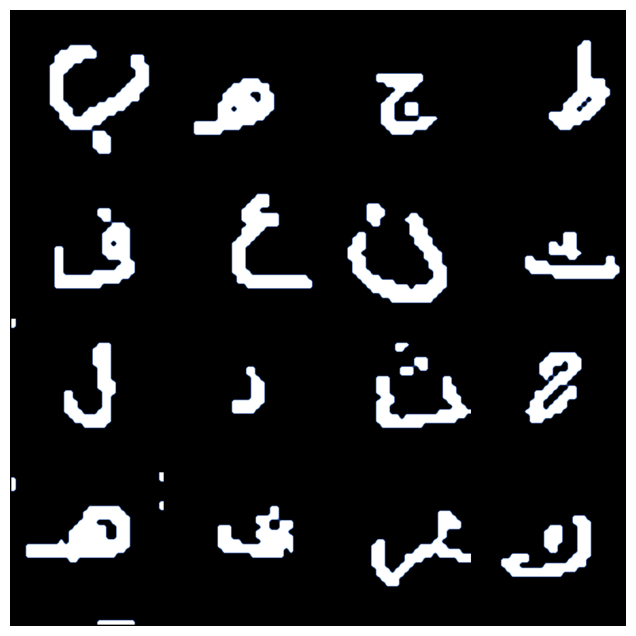

In [12]:
from torchvision.utils import make_grid

train_loader, val_loader, test_loader = create_arabic_dataloaders(CONFIG)

if train_loader:
    images, labels = next(iter(train_loader))

    images = images[:16]
    labels = labels[:16]


    grid = make_grid(images, nrow=4)

    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
else:
    logging.error("training data loader not created.")

### Core Training and Evaluation Functions

In [13]:

def train_model(model, model_name, config, train_dataloader, val_dataloader):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    # Define the specific path for this model's checkpoint
    best_model_path = os.path.join(config["checkpoints_dir"], f"{model_name}_best_model.pth")
    early_stopper = EarlyStopping(patience=config["early_stopping_patience"], checkpoint_path=best_model_path)

    start_time = time.time()
    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss, train_acc = 0, 0
        train_pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]", leave=False)
        for X, y in train_pbar:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        model.eval()
        val_loss, val_acc = 0, 0
        val_pbar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Val]", leave=False)
        with torch.no_grad():
            for X, y in val_pbar:
                X, y = X.to(DEVICE), y.to(DEVICE)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                val_acc += (y_pred_class == y).sum().item() / len(y_pred)

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)

        logging.info(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            logging.info("Early stopping triggered.")
            break

    total_time = time.time() - start_time
    logging.info(f"Training completed for {model_name} in {total_time:.2f} seconds.")

### Visualization Functions

In [ ]:
train_loader_arabic, val_loader_arabic, test_loader_arabic = create_arabic_dataloaders(CONFIG)

if train_loader_arabic and val_loader_arabic:
    for model_name in CONFIG["models_to_evaluate"]:
        logging.info(f"\n{'='*80}\nstarting pretrsining for : {model_name}\n{'='*80}")

        model = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=CONFIG["num_classes"]
        ).to(DEVICE)

        train_model(model, model_name, CONFIG, train_loader_arabic, val_loader_arabic)

        logging.info(f"\n{'='*80}\npre-training done for : {model_name}. best weights saved.\n{'='*80}")

    logging.info("pre-training done.")
else:
    logging.error("Could not create Arabic data loaders. Halting pre-training.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/50 [Train]:   0%|          | 0/179 [00:00<?, ?it/s]

In [2]:
import os
import shutil
from tqdm.auto import tqdm

# Path to the flat directory with all the training images
source_train_dir = "/content/ahar/train images 13440x32x32/train"

# A new directory to store the organized data
organized_train_dir = "/content/ahar/train_organized"

# Create the main organized directory
os.makedirs(organized_train_dir, exist_ok=True)

# Create a subdirectory for each of the 28 classes
for i in range(28):
    os.makedirs(os.path.join(organized_train_dir, str(i)), exist_ok=True)

print("Reorganizing training files...")

# Get all image files
image_files = [f for f in os.listdir(source_train_dir) if f.endswith('.png')]

# Move each file to its correct class folder
for filename in tqdm(image_files):
    try:
        # Extract label from filename (e.g., 'id_XXXX_label_YY.png')
        label = int(filename.split('_')[-1].split('.')[0]) - 1 # This is your logic

        # Define source and destination paths
        source_path = os.path.join(source_train_dir, filename)
        destination_path = os.path.join(organized_train_dir, str(label), filename)

        # Move the file
        shutil.move(source_path, destination_path)
    except (ValueError, IndexError) as e:
        print(f"Could not parse label from {filename}. Skipping. Error: {e}")

print("File reorganization complete.")


Reorganizing training files...


  0%|          | 0/13440 [00:00<?, ?it/s]

File reorganization complete.


In [5]:
import os
import shutil
from tqdm.auto import tqdm

# Path to the flat directory with all the training images
source_train_dir = "/content/ahar/test images 3360x32x32/test"

# A new directory to store the organized data
organized_train_dir = "/content/ahar/test_organized"

# Create the main organized directory
os.makedirs(organized_train_dir, exist_ok=True)

# Create a subdirectory for each of the 28 classes
for i in range(28):
    os.makedirs(os.path.join(organized_train_dir, str(i)), exist_ok=True)

print("Reorganizing training files...")

# Get all image files
image_files = [f for f in os.listdir(source_train_dir) if f.endswith('.png')]

# Move each file to its correct class folder
for filename in tqdm(image_files):
    try:
        # Extract label from filename (e.g., 'id_XXXX_label_YY.png')
        label = int(filename.split('_')[-1].split('.')[0]) - 1 # This is your logic

        # Define source and destination paths
        source_path = os.path.join(source_train_dir, filename)
        destination_path = os.path.join(organized_train_dir, str(label), filename)

        # Move the file
        shutil.move(source_path, destination_path)
    except (ValueError, IndexError) as e:
        print(f"Could not parse label from {filename}. Skipping. Error: {e}")

print("File reorganization complete.")


Reorganizing training files...


  0%|          | 0/3360 [00:00<?, ?it/s]

File reorganization complete.
